# Physics Informed Deep Learning (PIDL): 

we aim to solve the inverse problem, given the incomplete description of the differential equation we need to estimate the paramters given the system response in some physical domain.

#### Problem Statement: 

$$\frac{d^2 u}{dx^2} = f\left(u, x, \frac{du}{dx}\right)$$

here to simplify things we are guven with the form of the right hand side (it is independent of $u$, $\dot{u}$) has a form of $f(x) = ax + b\sin(cx)$ where $a,\, b,\, c \, \in \mathbb{R}$

#### imports:

In [1]:
import torch 
import numpy as np 
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### training data generation:

1. Boundary Conditions: 

In [2]:
x_bc = np.array([[0], [1]])
u_bc = np.array([[0], [0]])

2. Collocation Points: 

In [3]:
x_coll = np.random.uniform(0, 1, size=(1000, 1))
u_coll = (1/48)*(8*x_coll*(x_coll**2-1) - (3/np.pi**2)*np.sin(4*np.pi*x_coll))

3. Residual Values: 

In [4]:
all_res = np.zeros((1000, 1))

### proposed network architecture: 

we create two seperate neural networks, we wish to learn the function $f(x)$. one of the neural networks will do simple computations for the generating the force term and the other will give the gradients (also make sure to satisfy the coundary conditions) use the outputs to form the residual $r(\ddot{u}, x)$. 

In [9]:
class u_net(nn.Module):
  def __init__(self):
    super(u_net, self).__init__()
    self.hidden_layer1 = nn.Linear(1,50)

    self.hidden_layer2 = nn.Linear(50,50)
    self.hidden_layer3 = nn.Linear(50,50)
    self.hidden_layer4 = nn.Linear(50,50)
    self.hidden_layer5 = nn.Linear(50,50)
    self.hidden_layer6 = nn.Linear(50,50)
    
    

    self.output_layer = nn.Linear(50,1)

  def forward(self, x):
    inputs = x
    layer1_out = torch.tanh(self.hidden_layer1(inputs))
    layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
    layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
    layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
    layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
    layer6_out = torch.tanh(self.hidden_layer6(layer5_out))


    output = self.output_layer(layer6_out) 
    return output


class f_net(nn.Module):
  def __init__(self):
    super(f_net, self).__init__()
    self.hidden_layer1 = nn.Linear(1,150)

    self.hidden_layer2 = nn.Linear(150,150)
    self.hidden_layer3 = nn.Linear(150,150)
    self.hidden_layer4 = nn.Linear(150,150)
    self.hidden_layer5 = nn.Linear(150,150)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.relu = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.lrelu1 = nn.LeakyReLU(0.1)
    self.lrelu1 = nn.LeakyReLU(0.1)
    

    self.output_layer = nn.Linear(150,1)

  def forward(self, x):
    inputs = x
    layer1_out = torch.tanh(self.hidden_layer1(inputs))
    layer1_out = self.relu1(layer1_out)
    layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
    layer2_out = self.relu2(layer1_out)
    layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
    layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
    layer4_out = self.lrelu1(layer4_out)
    layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
    layer5_out = self.lrelu1(layer5_out)
    

    output = self.output_layer(layer5_out) 
    return output


In [10]:
UNET = u_net()
FNET = f_net()

UNET = UNET.to(device)
FNET = FNET.to(device)

mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(UNET.parameters())+ list(FNET.parameters()))

### residual function: 

In [11]:
def residual(x, UNET, FNET):
  u = UNET(x) 
  f = FNET(x)
  u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

  ode = u_xx - f
  return ode

### training loop: 

In [12]:
iterations = 10000

for epoch in range(iterations):
  optimizer.zero_grad()

  pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
  pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

  net_bc_out = UNET(pt_x_bc)
  mse_bc = mse(net_bc_out, pt_u_bc)

  
  pt_x_coll = Variable(torch.from_numpy(x_coll).float(), requires_grad=True).to(device)
  pt_u_coll = Variable(torch.from_numpy(u_coll).float(), requires_grad=False).to(device)
  pt_r_coll = Variable(torch.from_numpy(all_res).float(), requires_grad=False).to(device)

  r = residual(pt_x_coll, UNET, FNET)
  mse_r = mse(r, pt_r_coll)

  u_ = UNET(pt_x_coll)
  mse_u = mse(u_, pt_u_coll)

  loss = (100*mse_u)+mse_r+mse_bc

  loss.sum().backward()
  optimizer.step()

  if ((epoch+1)%100 == 0):
    with torch.autograd.no_grad():
      print(f"{epoch+1}: Loss = {loss.data:10}")

100: Loss = 0.034995004534721375
200: Loss = 0.0015192041173577309
300: Loss = 0.0011691305553540587
400: Loss = 0.0011417544446885586
500: Loss = 0.0012683342210948467
600: Loss = 0.0015420297859236598
700: Loss = 0.0010083680972456932
800: Loss = 0.0009853182127699256
900: Loss = 0.0009348450694233179
1000: Loss = 0.0009207188850268722
1100: Loss = 0.0009549676906317472
1200: Loss = 0.0017711137188598514
1300: Loss = 0.000749438360799104
1400: Loss = 0.0007411062251776457
1500: Loss = 0.0006549595855176449
1600: Loss = 0.0006119847530499101
1700: Loss = 0.0006452911184169352
1800: Loss = 0.000513532548211515
1900: Loss = 0.00047535746125504375
2000: Loss = 0.0023490197490900755
2100: Loss = 0.00039682211354374886
2200: Loss = 0.00037964156945236027
2300: Loss = 0.0003162242937833071
2400: Loss = 0.0003472869284451008
2500: Loss = 0.00028370582731440663
2600: Loss = 0.00025699473917484283
2700: Loss = 0.0019570444710552692
2800: Loss = 0.00022537415497936308
2900: Loss = 0.00021199288

### predicting the force function: 

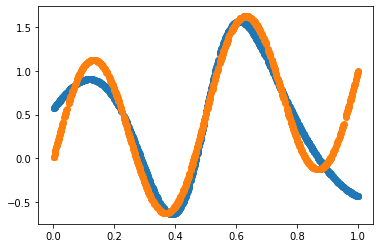

In [13]:
with torch.autograd.no_grad():
  learned_forcing_function = FNET(Variable(torch.from_numpy(x_coll).float(), requires_grad=True).to(device))

plt.scatter(x_coll, learned_forcing_function.numpy())
plt.scatter(x_coll, x_coll + np.sin(4*np.pi*x_coll))

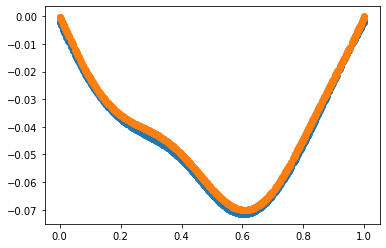

In [14]:
with torch.autograd.no_grad():
  learned_trajectory = UNET(Variable(torch.from_numpy(x_coll).float(), requires_grad=True).to(device))

plt.scatter(x_coll, learned_trajectory.numpy())
plt.scatter(x_coll, u_coll)